# Regression

In this notebook we demonstate how to fit a Gaussian process regression model.

In [1]:
from pprint import PrettyPrinter

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax as ox
from jax import jit
from jax.config import config
from jaxutils import Dataset
import jaxkern as jk

import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
pp = PrettyPrinter(indent=4)
key = jr.PRNGKey(123)

## Dataset

With the necessary modules imported, we simulate a dataset $\mathcal{D} = (\boldsymbol{x}, \boldsymbol{y}) = \{(x_i, y_i)\}_{i=1}^{100}$ with inputs $\boldsymbol{x}$ sampled uniformly on $(-3., 3)$ and corresponding independent noisy outputs

$$\boldsymbol{y} \sim \mathcal{N} \left(\sin(4\boldsymbol{x}) + \cos(2 \boldsymbol{x}), \textbf{I} * 0.3^2 \right).$$

We store our data $\mathcal{D}$ as a GPJax `Dataset` and create test inputs and labels for later.

In [2]:
n = 100
noise = 0.3

x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise

D = Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

To better understand what we have simulated, we plot both the underlying latent function and the observed data that is subject to Gaussian noise.

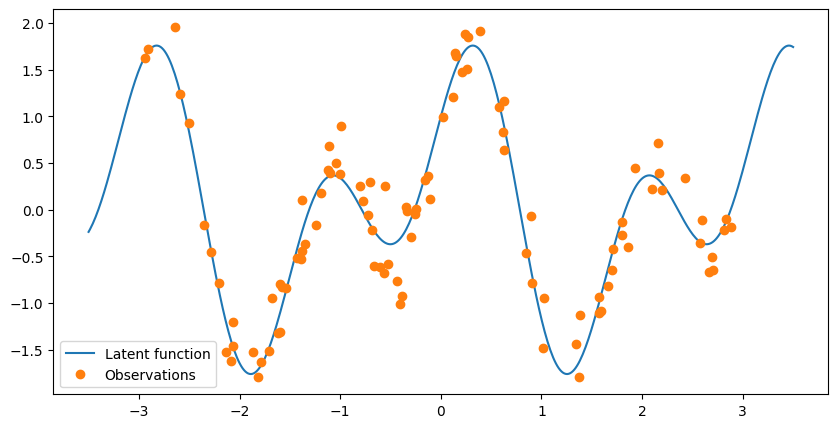

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(xtest, ytest, label="Latent function")
ax.plot(x, y, "o", label="Observations")
ax.legend(loc="best")

Our aim in this tutorial will be to reconstruct the latent function from our noisy observations $\mathcal{D}$ via Gaussian process regression. We begin by defining a Gaussian process prior in the next section.

## Defining the prior

A zero-mean Gaussian process (GP) places a prior distribution over real-valued functions $f(\cdot)$ where $f(\boldsymbol{x}) \sim \mathcal{N}(0, \mathbf{K}_{\boldsymbol{x}\boldsymbol{x}})$ for any finite collection of inputs $\boldsymbol{x}$.
Here $\mathbf{K}_{\boldsymbol{x}\boldsymbol{x}}$ is the Gram matrix generated by a user-specified symmetric, non-negative definite kernel function $k(\cdot, \cdot')$ with $[\mathbf{K}_{\boldsymbol{x}\boldsymbol{x}}]_{i, j} = k(x_i, x_j)$.
The choice of kernel function is critical as, among other things, it governs the smoothness of the outputs that our GP can generate.
For simplicity, we consider a radial basis function (RBF) kernel:
$$k(x, x') = \sigma^2 \exp\left(-\frac{\lVert x - x' \rVert_2^2}{2 \ell^2}\right).$$

On paper a GP is written as $f(\cdot) \sim \mathcal{GP}(\textbf{0}, k(\cdot, \cdot'))$, we can reciprocate this process in GPJax via defining a `Prior` with our chosen `RBF` kernel.

In [4]:
kernel = jk.RBF()
prior = gpx.Prior(kernel=kernel)


The above construction forms the foundation for GPJax's models. Moreover, the GP prior we have just defined can be represented by a [Distrax](https://github.com/deepmind/distrax) multivariate Gaussian distribution. Such functionality enables trivial sampling, and mean and covariance evaluation of the GP.

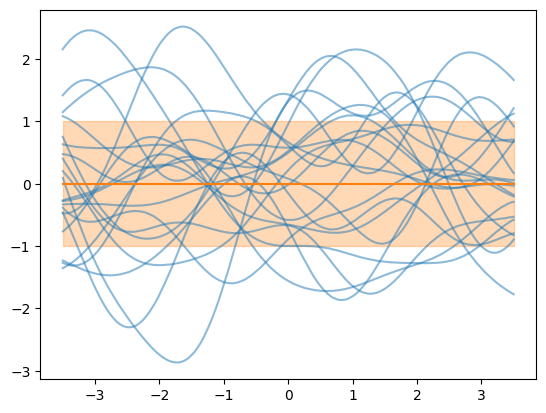

In [5]:
parameter_state = gpx.initialise(prior, key)
prior_dist = prior(parameter_state.params)(xtest)

prior_mean = prior_dist.mean()
prior_std = prior_dist.stddev()
samples = prior_dist.sample(seed=key, sample_shape=(20,)).T

plt.plot(xtest, samples, color="tab:blue", alpha=0.5)
plt.plot(xtest, prior_mean, color="tab:orange")
plt.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    color="tab:orange",
    alpha=0.3,
)
plt.show()

## Constructing the posterior

Having defined our GP, we proceed to define a description of our data $\mathcal{D}$ conditional on our knowledge of $f(\cdot)$ --- this is exactly the notion of a likelihood function $p(\mathcal{D} | f(\cdot))$. While the choice of likelihood is a critical in Bayesian modelling, for simplicity we consider a Gaussian with noise parameter $\alpha$
$$p(\mathcal{D} | f(\cdot)) = \mathcal{N}(\boldsymbol{y}; f(\boldsymbol{x}), \textbf{I} \alpha^2).$$
This is defined in GPJax through calling a `Gaussian` instance.

In [6]:
likelihood = gpx.Gaussian(num_datapoints=D.n)

The posterior is proportional to the prior multiplied by the likelihood, written as

  $$ p(f(\cdot) | \mathcal{D}) \propto p(f(\cdot)) * p(\mathcal{D} | f(\cdot)). $$

Mimicking this construct, the posterior is established in GPJax through the `*` operator.

In [7]:
posterior = prior * likelihood

<!-- ## Hyperparameter optimisation

Our kernel is parameterised by a length-scale $\ell^2$ and variance parameter $\sigma^2$, while our likelihood controls the observation noise with $\alpha^2$. Using Jax's automatic differentiation module, we can take derivatives of  -->

## Parameter state

So far, all of the objects that we've defined have been stateless. To give our model state, we can use the `initialise` function provided in GPJax. Upon calling this, a `ParameterState` class is returned that contains four dictionaries:

| Dictionary  | Description  |
|---|---|
|  `params` | Initial parameter values.  |
| `trainable`  | Boolean dictionary that determines the training status of parameters (`True` for being trained and `False` otherwise).  |
|  `bijectors` | Bijectors that can map parameters between the _unconstrained space_ and their original _constrained space_.  |

Further, upon calling `initialise`, we can state specific initial values for some, or all, of the parameters within our model. By default, the kernel lengthscale and variance and the likelihood's variance parameter are all initialised to 1. However, in the following cell, we'll demonstrate how the kernel lengthscale can be initialised to 0.5.

In [8]:
parameter_state = gpx.initialise(
    posterior, key, kernel={"lengthscale": jnp.array([0.5])}
)
print(type(parameter_state))

<class 'gpjax.parameters.ParameterState'>


Note, for this example a key is not strictly necessary as none of the parameters are stochastic variables. For this reason, it is valid to call `initialise` without supplying a key. For some models, such as the sparse spectrum GP, the parameters are themselves random variables and the key is therefore essential.

We can now unpack the `ParameterState` to receive each of the four components listed above.

In [9]:
params, trainable, bijectors = parameter_state.unpack()
pp.pprint(params)

{   'kernel': {   'lengthscale': Array([0.5], dtype=float64),
                  'variance': Array([1.], dtype=float64)},
    'likelihood': {'obs_noise': Array([1.], dtype=float64)},
    'mean_function': {}}


To motivate the purpose the `bijectors` more precisely, notice that our model hyperparameters $\{\ell^2, \sigma^2, \alpha^2 \}$ are all strictly positive, bijectors act to unconstrain these during the optimisation proceedure.

To train our hyperparameters, we optimising the marginal log-likelihood of the posterior with respect to them. We define the marginal log-likelihood with `marginal_log_likelihood` on the posterior.

In [10]:
negative_mll = jit(posterior.marginal_log_likelihood(D, negative=True))
negative_mll(params)

Array(113.9804237, dtype=float64)

Since most optimisers (including here) minimise a given function, we have realised the negative marginal log-likelihood and just-in-time (JIT) compiled this to accelerate training.

We can now define an optimiser with `optax`. For this example we'll use the `adam` optimiser.

In [11]:
optimiser = ox.adam(learning_rate=0.01)

inference_state = gpx.fit(
    objective=negative_mll,
    parameter_state=parameter_state,
    optax_optim=optimiser,
    num_iters=500,
)

  0%|          | 0/500 [00:00<?, ?it/s]

Similar to the `ParameterState` object above, the returned variable from the `fit` function is a class, namely an `InferenceState` object that contains the parameters' final values and a tracked array of the evaluation of our objective function throughout optimisation.

In [12]:
learned_params, training_history = inference_state.unpack()

pp.pprint(learned_params)

{   'kernel': {   'lengthscale': Array([0.4482576], dtype=float64),
                  'variance': Array([1.38353999], dtype=float64)},
    'likelihood': {'obs_noise': Array([0.06315212], dtype=float64)},
    'mean_function': {}}


## Prediction

Equipped with the posterior and a set of optimised hyperparameter values, we are now in a position to query our GP's predictive distribution at novel test inputs. To do this, we use our defined `posterior` and `likelihood` at our test inputs to obtain the predictive distribution as a `Distrax` multivariate Gaussian upon which `mean` and `stddev` can be used to extract the predictive mean and standard deviatation.

In [13]:
latent_dist = posterior(learned_params, D)(xtest)
predictive_dist = likelihood(learned_params, latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

With the predictions and their uncertainty acquired, we illustrate the GP's performance at explaining the data $\mathcal{D}$ and recovering the underlying latent function of interest.

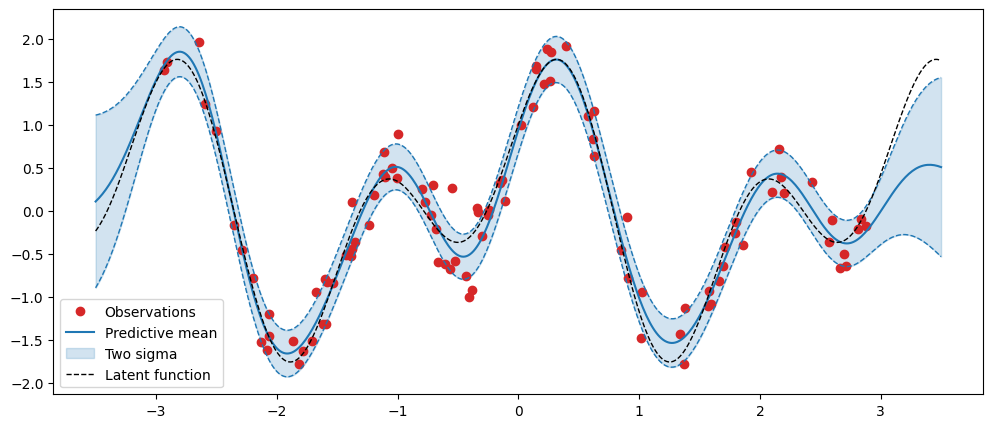

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", label="Observations", color="tab:red")
ax.plot(xtest, predictive_mean, label="Predictive mean", color="tab:blue")
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - predictive_std,
    predictive_mean + predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)
ax.plot(
    xtest,
    predictive_mean - predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)
ax.plot(
    xtest,
    predictive_mean + predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)

ax.plot(
    xtest, ytest, label="Latent function", color="black", linestyle="--", linewidth=1
)

ax.legend()

## System configuration

In [15]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Thomas Pinder & Daniel Dodd'

Author: Thomas Pinder & Daniel Dodd

Last updated: Thu Jan 12 2023

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.8.0

jax       : 0.4.1
jaxkern   : 0.0.4
matplotlib: 3.6.3
gpjax     : 0.5.8
optax     : 0.1.4

Watermark: 2.3.1

